In [ ]:
!pip install -q torchsummary


[notice] A new release of pip is available: 23.0.1 -> 23.3
[notice] To update, run: pip install --upgrade pip


# 데이터

## 데이터 준비

In [ ]:
!ls "drive/MyDrive/Colab Notebooks/Learning-PyTorch-Deeplearning-with-Hands-On-Projects/Part3/3. 개 품종 분류"
!unzip "drive/MyDrive/Colab Notebooks/Learning-PyTorch-Deeplearning-with-Hands-On-Projects/Part3/3. 개 품종 분류/dog-breed-identification.zip" -d dataset
!ls dataset

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
  inflating: dataset/train/83bcff6b55ee179a7c123fa6103c377a.jpg  
  inflating: dataset/train/83be6d622ab74a5e7e08b53eb8fd566a.jpg  
  inflating: dataset/train/83c2d7419b0429b9fe953bc1b6cddbec.jpg  
  inflating: dataset/train/83cf7d7cd2a759a93e2ffd95bea9c6fb.jpg  
  inflating: dataset/train/83d405858f0931722ef21e8ac0adee4d.jpg  
  inflating: dataset/train/83d4125a4c3c7dc5956563276cb1cd74.jpg  
  inflating: dataset/train/83f0bb565b2186dbcc6a9d009cb26ff2.jpg  
  inflating: dataset/train/83fad0718581a696132c96c166472627.jpg  
  inflating: dataset/train/83fbbcc9a612e3f712b1ba199da61f20.jpg  
  inflating: dataset/train/8403d8936430c2f05ab7d74d23c2c0cb.jpg  
  inflating: dataset/train/8406d837b2d7fac1c3cd621abb4c4f9e.jpg  
  inflating: dataset/train/840b67d26e5e43f8eb6430f62d4ba1ac.jpg  
  inflating: dataset/train/840db91ba4600148f3dcb06ec419b421.jpg  
  inflating: dataset/train/840dbad5a691c22611d85b2488bf4cbb.jpg  
  inflating: dataset/train/8410ced9ebc17

In [ ]:
!ls dataset/train| wc -l
!ls dataset/test | wc -l

10222
10357


## EDA

In [ ]:
import pandas as pd
from IPython.display import display

df = pd.read_csv("dataset/labels.csv")
display(df.head())

FileNotFoundError: ignored

breed
affenpinscher                      80
afghan_hound                      116
african_hunting_dog                86
airedale                          107
american_staffordshire_terrier     74
                                 ... 
welsh_springer_spaniel             79
west_highland_white_terrier        81
whippet                            95
wire-haired_fox_terrier            82
yorkshire_terrier                  82
Name: breed, Length: 120, dtype: int64

,breed,count
0,affenpinscher,80
1,afghan_hound,116
2,african_hunting_dog,86
3,airedale,107
4,american_staffordshire_terrier,74
...,...,...
115,welsh_springer_spaniel,79
116,west_highland_white_terrier,81
117,whippet,95
118,wire-haired_fox_terrier,82


,breed,count
97,scottish_deerhound,126
73,maltese_dog,117
1,afghan_hound,116
42,entlebucher,115
11,bernese_mountain_dog,114


max: 126
min: 66
mean: 85.18333333333334
median 82.0


<Axes: xlabel='breed'>

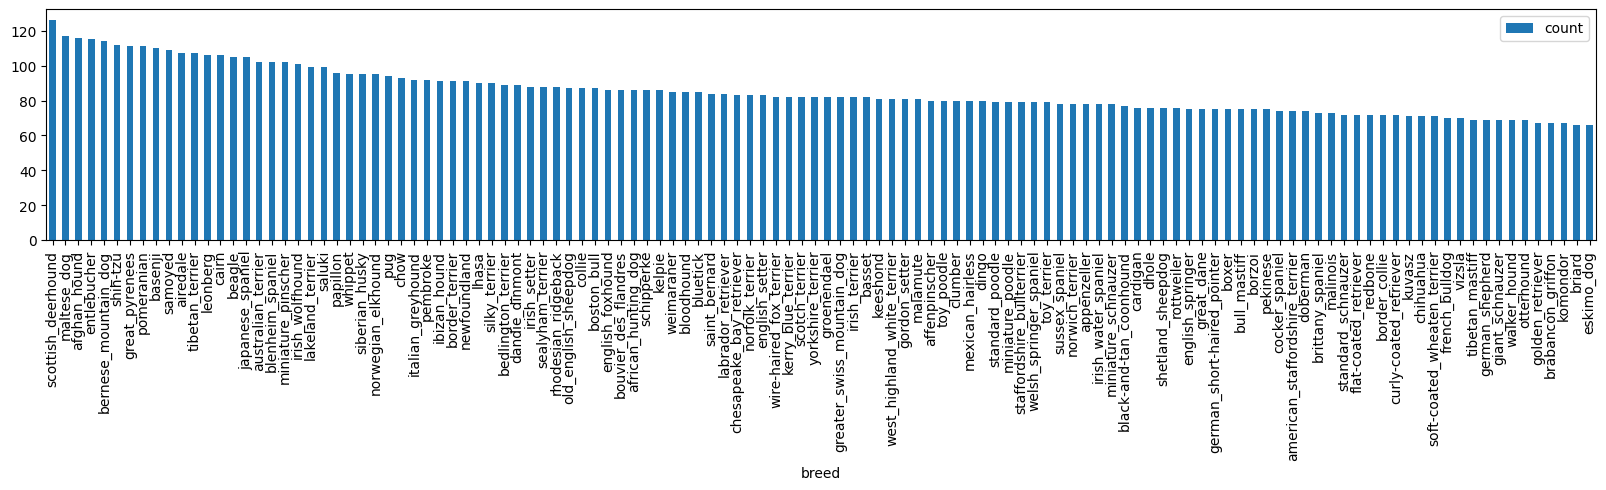

In [ ]:
df_count = df.groupby(["breed"])["breed"].count()
df_count = df_count.reset_index(name='count')
df_count = df_count.sort_values(['count'], ascending=False)
display(df_count.head())

print("max:", df_count['count'].max())
print("min:", df_count['count'].min())
print("mean:", df_count['count'].mean())
print("median", df_count['count'].median())

df_count.plot(kind='bar', x='breed', y='count', figsize=(20,3))

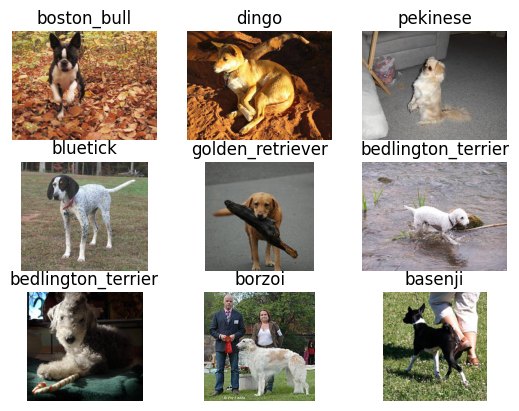

In [ ]:
# Sample image
import matplotlib.pyplot as plt
from PIL import Image

for i in range(9):
    plt.subplot(3,3,i+1)
    img = Image.open(f"dataset/train/{df.iloc[i].id}.jpg")

    plt.gca().set_title(df.iloc[i].breed)
    plt.imshow(img)
    plt.axis('off')

# Dataset

In [ ]:
import os
import random

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torch.utils.data import DataLoader
from torchvision import transforms
import numpy as np

In [ ]:
is_cuda = torch.cuda.is_available()
device = torch.device("cuda" if is_cuda else "cpu")
print(is_cuda, device)

True cuda


In [ ]:
seed = 1010
random.seed(seed)         # python seed
np.random.seed(seed)      # numpy seed
torch.manual_seed(seed)   # torch seed
if device == 'cuda':
  torch.cuda.manual_seed_all(seed)  # gpu seed

In [ ]:
from os.path import join

from PIL import Image
from torch.utils.data import random_split, dataset

class Dogs(dataset.Dataset):
  def __init__(self, root, train=True, transforms=None):

    self.train = train
    self.transforms = transforms

    # load image path and labels
    df = pd.read_csv(join(root, 'labels.csv'))
    self.class_names = df['breed'].unique().tolist()

    if train:
      dir = 'train'
      self.labels = df['breed'].tolist()
    else:
      dir = 'test'
      df = pd.read_csv(join(root, 'sample_submission.csv'))

    self.images = [join(root, dir, f"{id}.jpg") for id in df['id']]

  def __len__(self):
    return len(self.images)

  def __getitem__(self, i):
    image = Image.open(self.images[i])

    if self.transforms is not None:
      image = self.transforms(image)

    if self.train:
      label = self.class_names.index(self.labels[i])
    else:
      label = -1

    return image, label

In [ ]:
def get_dogs_datasets(
    val=0.2, root='dataset',
    train_transforms=None, test_transforms=None):
  # split
  origin = Dogs(
      root=root,
      train=True,
      transforms=train_transforms
  )
  val_samples = int(len(origin) * val)
  train_samples = len(origin) - val_samples

  # dataset
  trainset, valset = random_split(
      origin,
      (train_samples, val_samples),
  )
  valset.transforms = test_transforms
  testset = Dogs(
      root=root,
      train=False,
      transforms=test_transforms
  )

  return trainset, valset, testset

dataset_list = get_dogs_datasets(root='dataset')

# model
ResNet

In [ ]:
from torchsummary import summary

model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet50', pretrained=True)
print(model)

Using cache found in /home/omnious/.cache/torch/hub/pytorch_vision_v0.10.0
/usr/local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
model.fc = nn.Sequential(
    nn.Linear(2048, 512),
    nn.ReLU(),
    nn.Linear(512, 120)
)

print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
summary(model.to('cuda'), (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

In [ ]:
def load_resnet():
  model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet50', pretrained=True)

  for param in model.parameters():
    param.requires_grad = False

  model.fc = nn.Sequential(
    nn.Linear(2048, 512),
    nn.ReLU(),
    nn.Linear(512, 120)
  )

  return model

In [ ]:
model = load_resnet()
summary(model.to('cuda'), (3, 224, 224))

Using cache found in /home/omnious/.cache/torch/hub/pytorch_vision_v0.10.0


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

## Train

In [ ]:
def train(model, dataloader, criterion, optimizer, epoch, device):
  # train mode
  model.train()

  # 학습 통계
  running_loss = 0
  correct = 0

  for i, (data, targets) in enumerate(dataloader):
    data, targets = data.to(device), targets.to(device)

    optimizer.zero_grad()
    outputs = model(data)
    loss = criterion(outputs, targets)
    loss.backward()
    optimizer.step()

    running_loss += loss.item()

    # Accuracy 계산
    with torch.no_grad():
      _, predicted = torch.max(outputs, 1)
      correct += predicted.eq(targets.view_as(predicted)).sum()

  # Accuracy 출력
  data_num = len(dataloader.dataset)
  acc = 100. * correct / data_num
  print(
      f"[{epoch}/{EPOCH}]",
      f"train loss: {running_loss/len(dataloader):.4f}",
      f"train acc: {correct}/{data_num} ({acc:.2f}%)"
  )

  return running_loss/len(dataloader), acc

In [ ]:
def validation(model, dataloader, criterion, epoch, device):
  # eval 모드
  model.eval()

  # 검증 통계
  correct = 0
  running_loss = 0.

  with torch.no_grad():   # gradient 계산 안하기
    for i, (data, targets) in enumerate(dataloader):
      data, targets = data.to(device), targets.to(device)   # data device로 이동

      outputs = model(data)               # forward
      loss = criterion(outputs, targets)  # loss 계산

      running_loss += loss.item()

      # Accuracy 계산
      _, predicted = torch.max(outputs, 1)
      correct += predicted.eq(targets.view_as(predicted)).sum()

  # Accuracy 계산
  data_num = len(dataloader.dataset)
  acc = 100. * correct / data_num
  print(f'[{epoch}/{EPOCH}] valid loss: {running_loss/len(dataloader):.4f} valid acc: {correct}/{data_num} ({acc:.2f}%)\n')

  return running_loss/len(dataloader), acc

In [ ]:
# Hyperparameters
# Training
EPOCH = 30
BATCH_SIZE = 64
NUM_WORKERS = 1
LR = 1e-4
MODEL_ROOT = 'checkpoint'
os.makedirs(MODEL_ROOT, exist_ok=True)

# transform
train_transform = transforms.Compose([
  transforms.RandomResizedCrop((256, 256)),
  transforms.RandomHorizontalFlip(),
  transforms.ColorJitter(brightness=0.4,
                         contrast=0.4,
                         saturation=0.4),
  transforms.CenterCrop((224, 224)),
  transforms.ToTensor(),
  transforms.Normalize(mean=[0.485, 0.456, 0.406],
                       std=[0.229, 0.224, 0.225])
])
test_transform = transforms.Compose([
  transforms.Resize((256, 256)),
  transforms.CenterCrop((224, 224)),
  transforms.ToTensor(),
  transforms.Normalize(mean=[0.485, 0.456, 0.406],
                       std=[0.229, 0.224, 0.225])
])

# dataloader
trainset, valset, testset = get_dogs_datasets(
  val=0.1,
  train_transforms=train_transform,
  test_transforms=test_transform,
)

# dataloader
train_loader = DataLoader(
    dataset=trainset,
    shuffle=True,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
)
val_loader = DataLoader(
    dataset=valset,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
)
test_loader = DataLoader(
    dataset=testset,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
)

# Model
model = load_resnet()
model = model.to(device)

# Loss, Optimizer 정의
criterion = nn.CrossEntropyLoss()
optimizer = optim.RMSprop(model.parameters(), lr=LR)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

train_losses = []
val_losses = []
max_acc = 0
last_checkpoint = None

for epoch in range(1, EPOCH+1):
  tloss, tacc = train(model, train_loader, criterion, optimizer, epoch, device)
  vloss, vacc = validation(model, val_loader, criterion, epoch, device)

  train_losses.append(tloss)
  val_losses.append(vloss)

  scheduler.step()

  if vacc >= max_acc:
    max_acc = vacc
    last_checkpoint = f"{MODEL_ROOT}/resnet50-ep{epoch}-{vacc:.2f}.pt"
    torch.save(model.state_dict(), last_checkpoint)


Using cache found in /home/omnious/.cache/torch/hub/pytorch_vision_v0.10.0
/usr/local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


[1/30] train loss: 3.9723 train acc: 2161/9200 (23.49%)
[1/30] valid loss: 3.2302 valid acc: 411/1022 (40.22%)

[2/30] train loss: 2.8156 train acc: 4447/9200 (48.34%)
[2/30] valid loss: 2.3447 valid acc: 563/1022 (55.09%)

[3/30] train loss: 2.1899 train acc: 5225/9200 (56.79%)
[3/30] valid loss: 1.9450 valid acc: 598/1022 (58.51%)

[4/30] train loss: 1.8584 train acc: 5534/9200 (60.15%)
[4/30] valid loss: 1.7005 valid acc: 636/1022 (62.23%)

[5/30] train loss: 1.6589 train acc: 5766/9200 (62.67%)
[5/30] valid loss: 1.4860 valid acc: 672/1022 (65.75%)

[6/30] train loss: 1.5369 train acc: 5883/9200 (63.95%)
[6/30] valid loss: 1.4378 valid acc: 680/1022 (66.54%)

[7/30] train loss: 1.4354 train acc: 6010/9200 (65.33%)
[7/30] valid loss: 1.3236 valid acc: 699/1022 (68.40%)

[8/30] train loss: 1.3808 train acc: 6065/9200 (65.92%)
[8/30] valid loss: 1.3368 valid acc: 670/1022 (65.56%)

[9/30] train loss: 1.3447 train acc: 6036/9200 (65.61%)
[9/30] valid loss: 1.2692 valid acc: 668/1022 (6

### 추론

In [ ]:
def inference(model, image, device, root='dataset'):
  df = pd.read_csv(join(root, 'labels.csv'))
  class_names = df['breed'].unique().tolist()

  transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.CenterCrop((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225])
  ])

  image = transform(image)
  image = image.unsqueeze(0).to(device)

  model.eval()
  model = model.to(device)

  outputs = model(image)
  _, predicted = torch.max(outputs, 1)
  print(predicted)
  print(class_names[predicted.item()])

In [ ]:
is_cuda = torch.cuda.is_available()
device = torch.device("cuda" if is_cuda else "cpu")

last_checkpoint = "/content/drive/MyDrive/Colab Notebooks/프로젝트로 시작하는 Pytorch/5.3/checkpoint/resnet50-ep50-70.35.pt"
model = load_resnet()
model.load_state_dict(torch.load(last_checkpoint))

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


RuntimeError: ignored

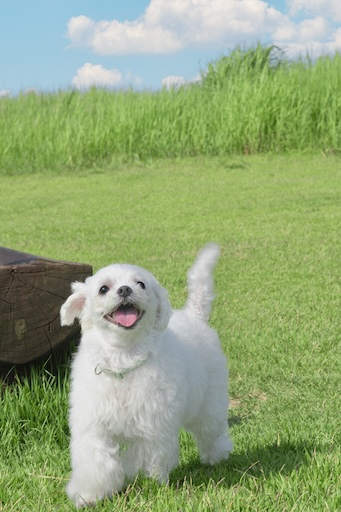

In [ ]:
img = Image.open("mong.jpg")
img

In [ ]:
inference(model, img, device)

tensor([11], device='cuda:0')
maltese_dog


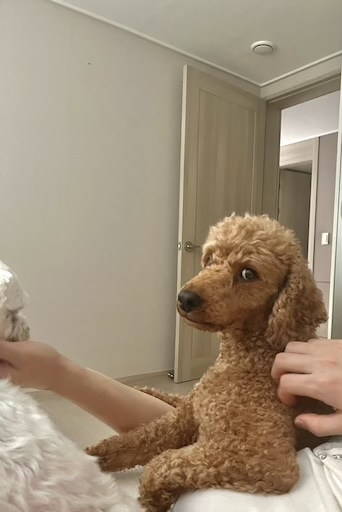

In [ ]:
img = Image.open("coco.jpg")
img

In [ ]:
inference(model, img, device)

tensor([104], device='cuda:0')
miniature_poodle
